In [ ]:
"""
Utilizing Fully Connected Neural Network for fault pattern classification,
for Fault Detection and Identification Course, KNTU, Spring 2023.

Programmed by Ardavan Modarres
ardavan.modarres@email.kntu.ac.ir
* 2023-05-20: Initial coding
"""

In [ ]:
# Imports
import torch
import torch.nn.functional as F                    # Parameterless functions, like activation functions
from torch import optim                            # For optimizers like SGD, Adam, etc.
from torch import nn                               # All neural network modules
from torch.utils.data import DataLoader, Dataset   # dataset managment by creating mini batches etc.
from tqdm import tqdm                              # For progress bar!
import matplotlib.pyplot as plt                    # for plotting!
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sn

In [ ]:
!pip install torchmetrics
import torchmetrics

## The previously segmented signals obtained from case western dataset are loaded and used.

(1449, 840)
(1449, 420)
(1449, 420)


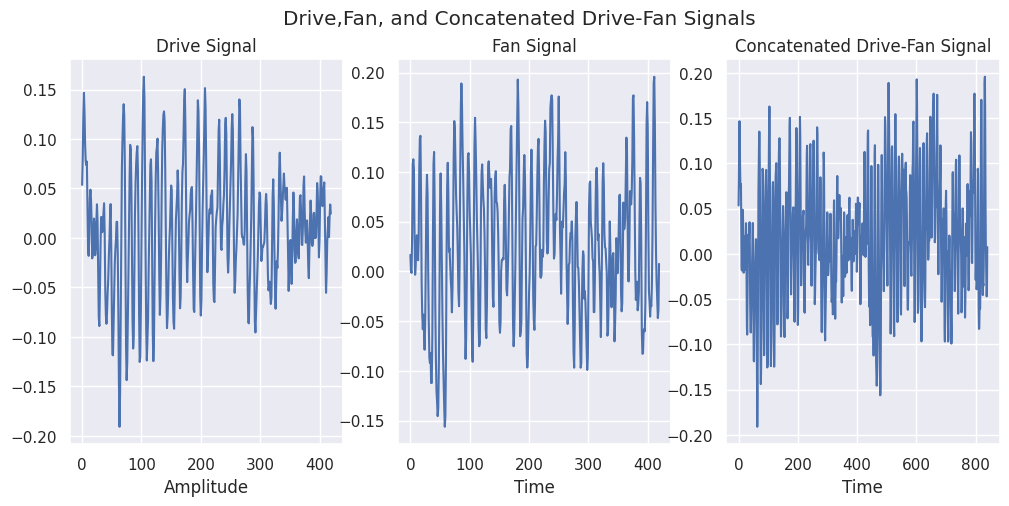

In [ ]:
data = np.array(pd.read_csv('/content/drive/MyDrive/CWRU/data.csv'))
drive = np.array(pd.read_csv('/content/drive/MyDrive/CWRU/drive.csv'))
fan = np.array(pd.read_csv('/content/drive/MyDrive/CWRU/fan.csv'))
target = np.array(pd.read_csv('/content/drive/MyDrive/CWRU/target.csv')).reshape(-1)

print(data.shape)
print(drive.shape)
print(fan.shape)

sn.set_theme(style="darkgrid")
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(drive[85, :])
plt.xlabel("Time")
plt.xlabel("Amplitude")
plt.title("Drive Signal")

plt.subplot(1, 3, 2)
plt.plot(fan[85, :])
plt.xlabel("Time")
plt.title("Fan Signal")

plt.subplot(1, 3, 3)
plt.plot(data[85, :])
plt.xlabel("Time")
plt.title("Concatenated Drive-Fan Signal")
plt.suptitle("Drive,Fan, and Concatenated Drive-Fan Signals")
plt.show()

## Defining Custom Dataset and Neural Network and Training Fully Connected Network (MLP)

In [ ]:
class CustomSet(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).to(torch.float32)
        self.y = torch.from_numpy(y).to(torch.long)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.x.shape[0]

### MLP Definition

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        # defining layers and activation functions
        self.fc1 = nn.Linear(input_size, 120)
        self.fc2 = nn.Linear(120, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### MLP Instanciation for Classification From Drvie Signal

In [ ]:
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
input_size = 420
num_classes = 4
learning_rate = 4e-3
num_epochs = 25
batch_size = 64

In [ ]:
# Initialize network
model_drive = MLP(input_size=input_size, num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_drive = optim.Adam(model_drive.parameters(), lr=learning_rate)

### MLP Instanciation for Classification From Fan Signal

In [ ]:
# Initialize network
model_fan = MLP(input_size=input_size, num_classes=num_classes).to(device)

# optimizer
optimizer_fan = optim.Adam(model_fan.parameters(), lr=learning_rate)

### MLP Instanciation for Classification From Concatenated Drive-Fan Signal

In [ ]:
input_size = 840
# Initialize network
model_drive_fan = MLP(input_size=input_size, num_classes=num_classes).to(device)

# optimizer
optimizer_drive_fan = optim.Adam(model_drive_fan.parameters(), lr=learning_rate)

## Training Procedure useful functions

In [ ]:
def get_info(model, loader):
  batch_loss = []
  epoch_loss = []
  temp_loss = []
  num_correct = 0
  num_samples = 0
  model.eval()
  with torch.no_grad():
    for (data, targets) in loader:
      # Get data to device
      data = data.to(device=device)
      targets = targets.to(device=device)

      # Forward
      logits = model(data)
      _, predictions = logits.max(1)
      loss = criterion(logits, targets)

      # Taking record of losses
      batch_loss.append(loss.item())

      # Check how many we got correct
      num_correct += (predictions == targets).sum()
      # Keep track of number of samples
      num_samples += predictions.size(0)
  model.train()
  return (num_correct/num_samples).item(), sum(batch_loss)/len(batch_loss)

In [ ]:
# Train Network
def Train(model, device, criterion, optimizer, num_epochs):
  train_loss = []
  validation_loss = []
  train_acc = []
  validation_acc = []
  for epoch in range(num_epochs):
      for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
          # Get data to device
          data = data.to(device=device)
          targets = targets.to(device=device)

          # Forward
          logits = model(data)
          loss = criterion(logits, targets)

          # Backward
          optimizer.zero_grad()
          loss.backward()

          # Gradient descent or adam step
          optimizer.step()

      # Taking record of losses
      tr_acc, tr_loss = get_info(model, train_loader)
      val_acc, val_loss = get_info(model, validation_loader)
      train_loss.append(tr_loss)
      validation_loss.append(val_loss)
      train_acc.append(tr_acc)
      validation_acc.append(val_acc)

  plt.figure(figsize=(10, 6))
  #plot 1:
  plt.subplot(1, 2, 1)
  plt.plot(train_acc)
  plt.plot(validation_acc)
  plt.title("Accuracy")
  plt.legend(['Train Accuracy', 'Validation Accuracy'])
  #plot 2:
  plt.subplot(1, 2, 2)
  plt.plot(train_loss)
  plt.plot(validation_loss)
  plt.title("Loss")
  plt.legend(['Train Loss', 'Validation Loss'])
  plt.suptitle("Performance")
  plt.show()

## Defining a simple function for checking accuracy

In [ ]:
# Check accuracy on training & test to see how good our model
def get_acc(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        # Loop through the data
        for x, y in loader:

            # Move data to device
            x = x.to(device=device)
            y = y.to(device=device)

            # Forward pass
            logits = model(x)
            _, predictions = logits.max(1)

            # Check how many we got correct
            num_correct += (predictions == y).sum()

            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples

### Training on Drive Dataset

In [ ]:
dataset = CustomSet(drive, target)
train_set, validation_set, test_set = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

#### Training Procedure

100%|██████████| 19/19 [00:00<00:00, 286.54it/s]


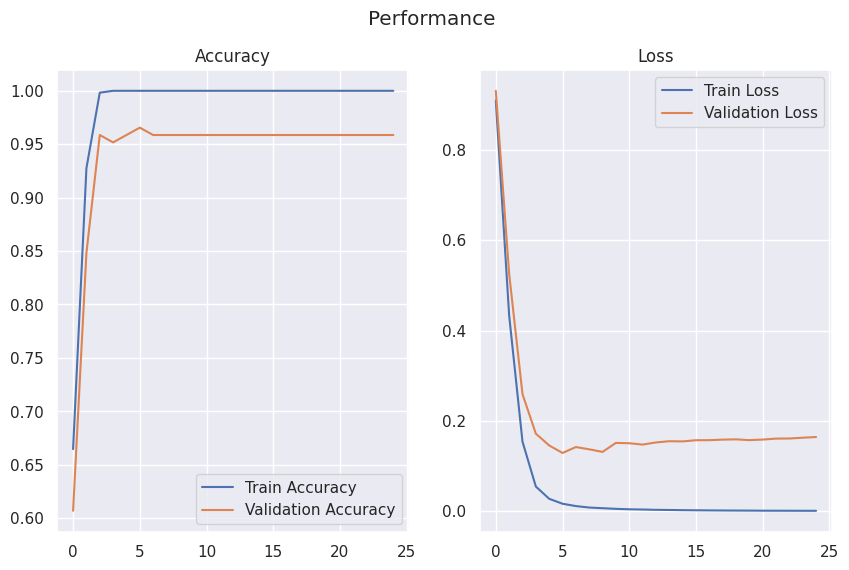

In [ ]:
Train(model_drive, device, criterion, optimizer_drive, num_epochs)

Over-fitting is observed!

In [ ]:
# Check accuracy on training & test
print(f"Accuracy on training set: {get_acc(train_loader, model_drive)*100:.2f}")
print(f"Accuracy on training set: {get_acc(validation_loader, model_drive)*100:.2f}")
print(f"Accuracy on test set: {get_acc(test_loader, model_drive)*100:.2f}")

Accuracy on training set: 100.00
Accuracy on training set: 95.86
Accuracy on test set: 95.14


Accuracy Of Model On Test Data Is :  tensor(94.4305)
Percision Of Model On Test Data Is :  tensor(95.0531)
Recall Of Model On Test Data Is :  tensor(94.4305)
F1-Score Of Model On Test Data Is :  tensor(94.4460)

Confusion Matrix Of Model On Test Data Is : 


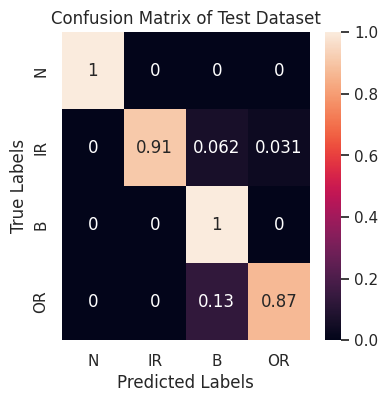

In [ ]:
predictions = torch.zeros(len(test_set))
targets = torch.zeros(len(test_set))
pointer = 0

model_drive.eval()
with torch.no_grad():
  for x, y in test_loader:
    logits = model_drive(x)
    _, preds = logits.max(1)
    predictions[pointer: pointer+x.shape[0]] = preds
    targets[pointer: pointer+x.shape[0]] = y
    pointer+=x.shape[0]


  accuracy = torchmetrics.Accuracy(task="multiclass", average='macro', num_classes=4)
  precision = torchmetrics.Precision(task="multiclass", average='macro', num_classes=4)
  recall = torchmetrics.Recall(task="multiclass", average='macro', num_classes=4)
  f1score = torchmetrics.F1Score(task="multiclass", average='macro', num_classes=4)
  confmat = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=4)

  a = accuracy(predictions, targets.reshape(-1,).to(dtype=torch.int64))
  p = precision(predictions, targets.reshape(-1,).to(dtype=torch.int64))
  r = recall(predictions, targets.reshape(-1,).to(dtype=torch.int64))
  f1s = f1score(predictions, targets.reshape(-1,).to(dtype=torch.int64))
  cm = confmat(predictions, targets.reshape(-1,).to(dtype=torch.int64))


  print("Accuracy Of Model On Test Data Is : ", 100*a)
  print("Percision Of Model On Test Data Is : ", 100*p)
  print("Recall Of Model On Test Data Is : ", 100*r)
  print("F1-Score Of Model On Test Data Is : ", 100*f1s)
  print("")

  print("Confusion Matrix Of Model On Test Data Is : ")
  cm = cm/cm.sum(dim=1).reshape(4,1)
  plt.figure(figsize = (4, 4))
  sn.heatmap(cm, annot=True, xticklabels=['N', 'IR', 'B', 'OR'],
            yticklabels=['N', 'IR', 'B', 'OR'])
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title("Confusion Matrix of Test Dataset")
  plt.show()

### Training on Fan Dataset

In [ ]:
dataset = CustomSet(fan, target)
train_set, validation_set, test_set = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

#### Training Procedure

100%|██████████| 19/19 [00:00<00:00, 448.31it/s]


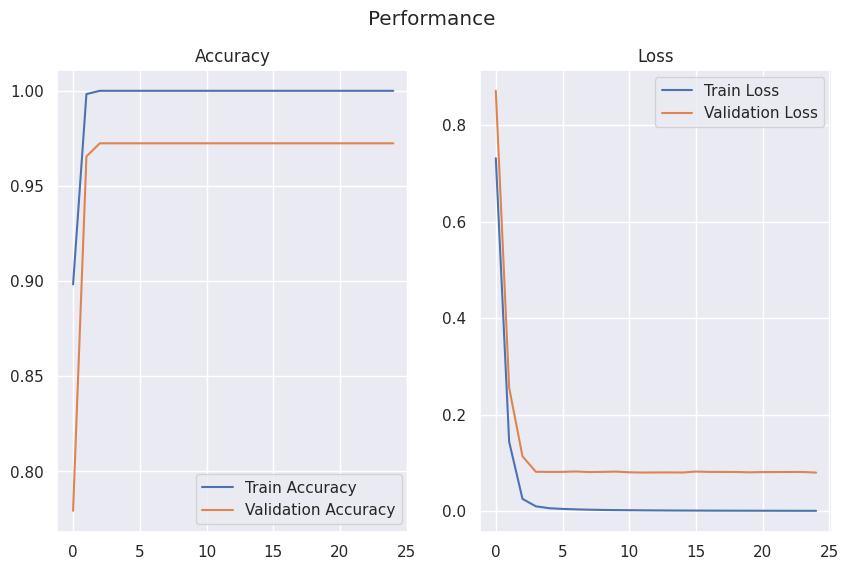

In [ ]:
Train(model_fan, device, criterion, optimizer_fan, num_epochs)

In [ ]:
# Check accuracy on training & test
print(f"Accuracy on training set: {get_acc(train_loader, model_fan)*100:.2f}")
print(f"Accuracy on training set: {get_acc(validation_loader, model_fan)*100:.2f}")
print(f"Accuracy on test set: {get_acc(test_loader, model_fan)*100:.2f}")

Accuracy on training set: 100.00
Accuracy on training set: 97.24
Accuracy on test set: 97.92


Accuracy Of Model On Test Data Is :  tensor(97.5000)
Percision Of Model On Test Data Is :  tensor(97.1154)
Recall Of Model On Test Data Is :  tensor(97.5000)
F1-Score Of Model On Test Data Is :  tensor(97.1536)

Confusion Matrix Of Model On Test Data Is : 


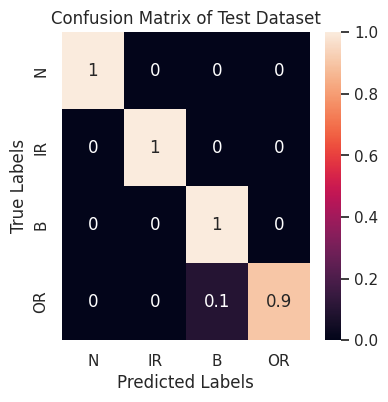

In [ ]:
predictions = torch.zeros(len(test_set))
targets = torch.zeros(len(test_set))
pointer = 0

model_fan.eval()
with torch.no_grad():
  for x, y in test_loader:
    logits = model_fan(x)
    _, preds = logits.max(1)
    predictions[pointer: pointer+x.shape[0]] = preds
    targets[pointer: pointer+x.shape[0]] = y
    pointer+=x.shape[0]


  accuracy = torchmetrics.Accuracy(task="multiclass", average='macro', num_classes=4)
  precision = torchmetrics.Precision(task="multiclass", average='macro', num_classes=4)
  recall = torchmetrics.Recall(task="multiclass", average='macro', num_classes=4)
  f1score = torchmetrics.F1Score(task="multiclass", average='macro', num_classes=4)
  confmat = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=4)

  a = accuracy(predictions, targets.reshape(-1,).to(dtype=torch.int64))
  p = precision(predictions, targets.reshape(-1,).to(dtype=torch.int64))
  r = recall(predictions, targets.reshape(-1,).to(dtype=torch.int64))
  f1s = f1score(predictions, targets.reshape(-1,).to(dtype=torch.int64))
  cm = confmat(predictions, targets.reshape(-1,).to(dtype=torch.int64))


  print("Accuracy Of Model On Test Data Is : ", 100*a)
  print("Percision Of Model On Test Data Is : ", 100*p)
  print("Recall Of Model On Test Data Is : ", 100*r)
  print("F1-Score Of Model On Test Data Is : ", 100*f1s)
  print("")

  print("Confusion Matrix Of Model On Test Data Is : ")
  cm = cm/cm.sum(dim=1).reshape(4,1)
  plt.figure(figsize = (4, 4))
  sn.heatmap(cm, annot=True, xticklabels=['N', 'IR', 'B', 'OR'],
            yticklabels=['N', 'IR', 'B', 'OR'])
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title("Confusion Matrix of Test Dataset")
  plt.show()

### Training on Drive-Fan Dataset

In [ ]:
dataset = CustomSet(data, target)
train_set, validation_set, test_set = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

#### Training Procedure

100%|██████████| 19/19 [00:00<00:00, 139.18it/s]


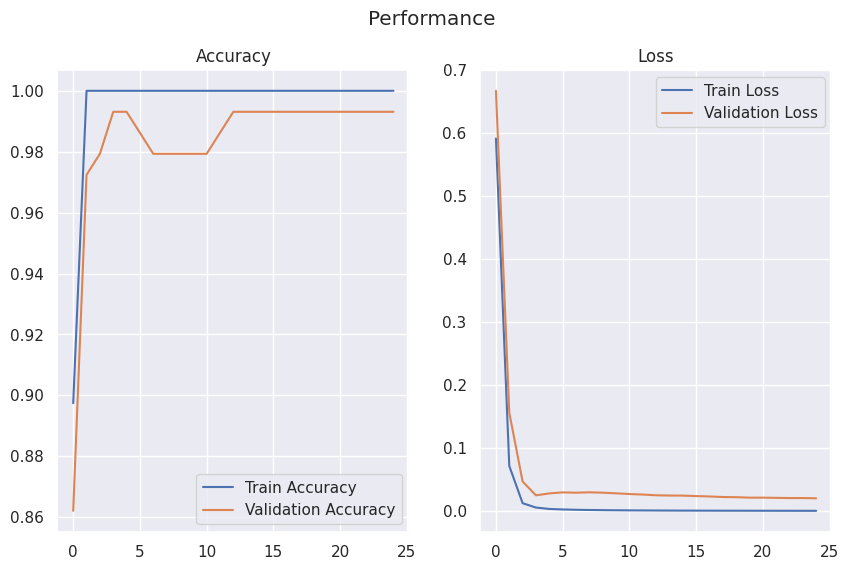

In [ ]:
Train(model_drive_fan, device, criterion, optimizer_drive_fan, num_epochs)

In [ ]:
# Check accuracy on training & test
print(f"Accuracy on training set: {get_acc(train_loader, model_drive_fan)*100:.2f}")
print(f"Accuracy on training set: {get_acc(validation_loader, model_drive_fan)*100:.2f}")
print(f"Accuracy on test set: {get_acc(test_loader, model_drive_fan)*100:.2f}")

Accuracy on training set: 100.00
Accuracy on training set: 99.31
Accuracy on test set: 98.61


Accuracy Of Model On Test Data Is :  tensor(97.7273)
Percision Of Model On Test Data Is :  tensor(98.5714)
Recall Of Model On Test Data Is :  tensor(97.7273)
F1-Score Of Model On Test Data Is :  tensor(98.0742)

Confusion Matrix Of Model On Test Data Is : 


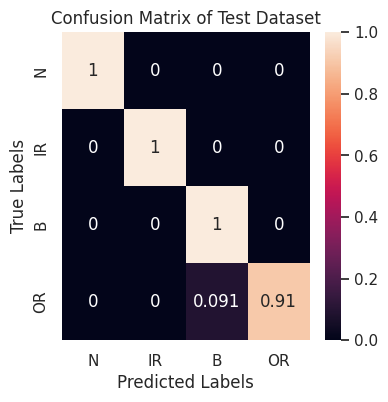

In [ ]:
predictions = torch.zeros(len(test_set))
targets = torch.zeros(len(test_set))
pointer = 0

model_drive_fan.eval()
with torch.no_grad():
  for x, y in test_loader:
    logits = model_drive_fan(x)
    _, preds = logits.max(1)
    predictions[pointer: pointer+x.shape[0]] = preds
    targets[pointer: pointer+x.shape[0]] = y
    pointer+=x.shape[0]


  accuracy = torchmetrics.Accuracy(task="multiclass", average='macro', num_classes=4)
  precision = torchmetrics.Precision(task="multiclass", average='macro', num_classes=4)
  recall = torchmetrics.Recall(task="multiclass", average='macro', num_classes=4)
  f1score = torchmetrics.F1Score(task="multiclass", average='macro', num_classes=4)
  confmat = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=4)

  a = accuracy(predictions, targets.reshape(-1,).to(dtype=torch.int64))
  p = precision(predictions, targets.reshape(-1,).to(dtype=torch.int64))
  r = recall(predictions, targets.reshape(-1,).to(dtype=torch.int64))
  f1s = f1score(predictions, targets.reshape(-1,).to(dtype=torch.int64))
  cm = confmat(predictions, targets.reshape(-1,).to(dtype=torch.int64))


  print("Accuracy Of Model On Test Data Is : ", 100*a)
  print("Percision Of Model On Test Data Is : ", 100*p)
  print("Recall Of Model On Test Data Is : ", 100*r)
  print("F1-Score Of Model On Test Data Is : ", 100*f1s)
  print("")

  print("Confusion Matrix Of Model On Test Data Is : ")
  cm = cm/cm.sum(dim=1).reshape(4,1)
  plt.figure(figsize = (4, 4))
  sn.heatmap(cm, annot=True, xticklabels=['N', 'IR', 'B', 'OR'],
            yticklabels=['N', 'IR', 'B', 'OR'])
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title("Confusion Matrix of Test Dataset")
  plt.show()